<a href="https://colab.research.google.com/github/gqkd/MRI_Brain_Tumor_Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#first download the dataset from this link, you need to be logged in
# https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/download?datasetVersionNumber=1
# save it in your google drive, for this notebook this is the path /content/drive/MyDrive/Datasets/Brain_MRI_Images_for_Brain_tumor_detection/archive.zip
# make a new directory
!mkdir dataset
%cd dataset
!cp /content/drive/MyDrive/Datasets/Brain_MRI_Images_for_Brain_tumor_detection/archive.zip .
!unzip -q archive.zip

/content/dataset


In [54]:
import pandas as pd
import os
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import entropy, skew

In [4]:
def load_data(parent_folder_path):
  path_parent = parent_folder_path + '/**'
  X=[]
  y=[]
  for path in glob.glob(path_parent, recursive=True):
    if os.path.isfile(path):
      img = cv2.imread(path)
      X.append(img)
      if os.path.basename(os.path.dirname(path)) == "yes":
        y.append(1)
      else:
        y.append(0)
  return np.array(X), np.array(y)

def plot_classes_distribution(y,name='') -> None:
  plt.figure(figsize=(10,5))

  # Check if y is not a list (single array)
  if not isinstance(y,list):
    classes, counts = np.unique(y, return_counts=True)

    plt.bar(classes,counts,width=0.5,color=['green','red'])
    plt.xticks(classes, ['No','Yes'])
    plt.title(f'Classes distribution {name}')
  else:

    y_max=0 # Variable to store the maximum y-axis value across all subplots

    plt.suptitle('Classes distribution')
    for i,el in enumerate(y):
      classes, counts = np.unique(el, return_counts=True)
      plt.subplot(1,3,i+1)
      plt.bar(classes,counts,width=0.5,color=['green','red'])
      plt.xticks(classes, ['No','Yes'])
      plt.title(f'{name[i]}')

      y_max = max(y_max, max(counts)) # Update the maximum y value

      # Set a common y-axis range for all subplots
      for ax in plt.gcf().get_axes():
        ax.set_ylim(0, y_max+10) # Add some extra margin to the maximum y value

  plt.tight_layout()

In [5]:
path = "/content/dataset/brain_tumor_dataset"
X, y = load_data(path)

<ipython-input-4-fedcd6caebc5>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


Text(0.5, 1.0, 'Distribution of ratios')

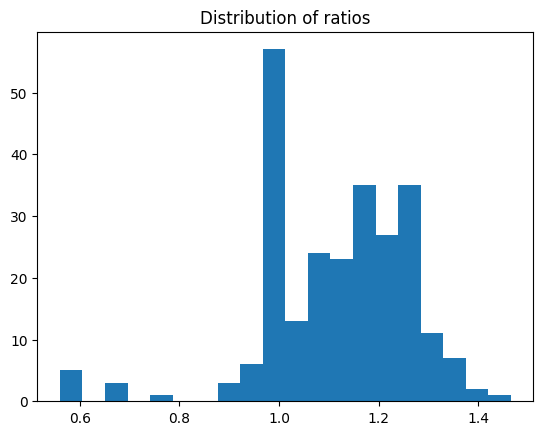

In [6]:
#EDA

#size of the images
list_sizes = []
list_ratios = []
for img in X:
  list_sizes.append(img.shape)
  list_ratios.append(img.shape[0]/img.shape[1])

# plt.hist(list_sizes)
plt.figure()
_ = plt.hist(list_ratios, bins=20)
plt.title('Distribution of ratios')

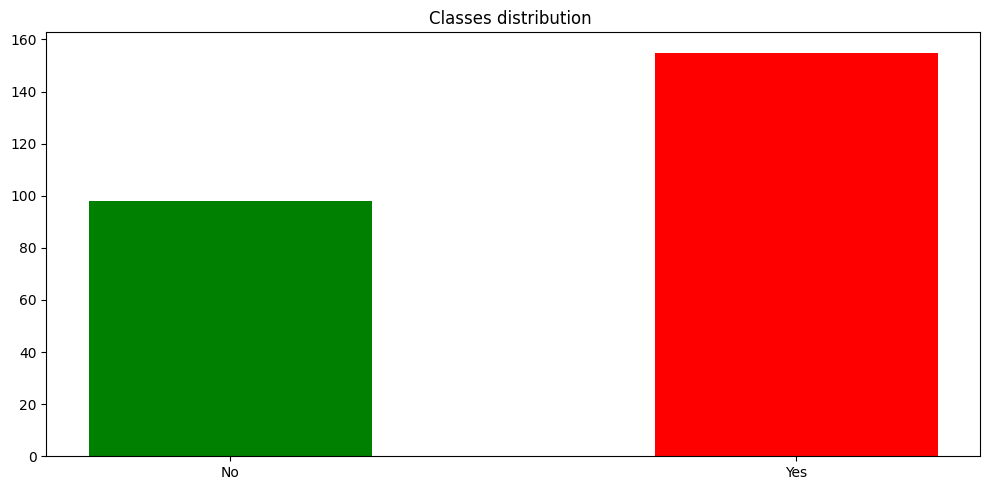

In [7]:
#distribution of classes initial dataset
plot_classes_distribution(y,name='')

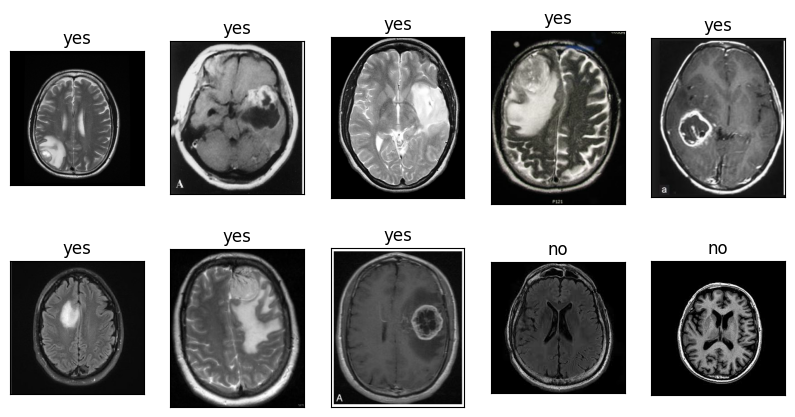

In [8]:
#plot examples from original dataset

plt.figure(figsize=(10,5))
for i in range(10):
  rnd = random.randint(0,len(X))
  plt.subplot(2,5,i+1)
  plt.imshow(X[rnd])
  plt.xticks([])
  plt.yticks([])
  plt.title('yes' if y[rnd]==1 else 'no')
  # plt.tight_layout()

In [47]:
range(len(X))

range(0, 253)

In [9]:
# splitting
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_remain, y_remain, test_size=0.5, random_state=42)

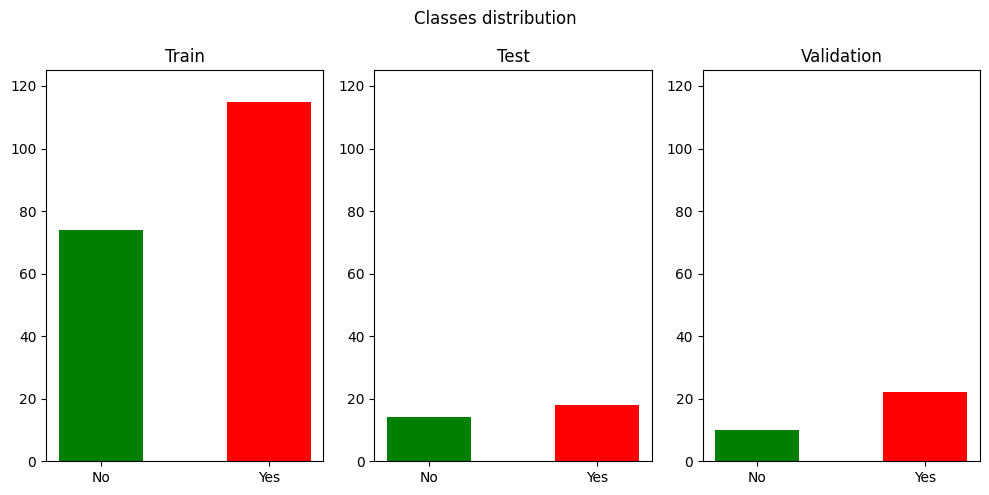

In [10]:
#distribution of classes train test and validation
plot_classes_distribution([y_train,y_test,y_val],['Train','Test','Validation'])

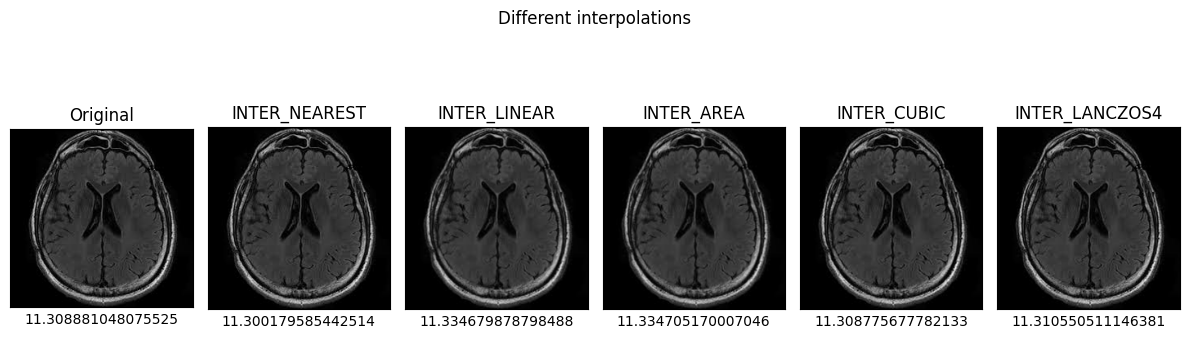

In [27]:

IMG_SIZE = (224,224)
img = X[0]

#different interpolations
dict_interpolations = {
  'INTER_NEAREST': cv2.INTER_NEAREST,  # fastest, blockiest
  'INTER_LINEAR': cv2.INTER_LINEAR,   # good compromise
  'INTER_AREA': cv2.INTER_AREA,    # slower, smoother than INTER_LINEAR
  'INTER_CUBIC': cv2.INTER_CUBIC,   # slowest, smoothest
  'INTER_LANCZOS4': cv2.INTER_LANCZOS4,  # even slower, even smoother
}

plt.figure(figsize=(12,4))
plt.suptitle('Different interpolations')
plt.subplot(1,6,1)
plt.imshow(img)
plt.title('Original')
plt.xticks([])
plt.yticks([])
plt.xlabel(f'{entropy(img.ravel())}')

for i,interp in enumerate(dict_interpolations):
  plt.subplot(1,6,i+2)
  imginterp = cv2.resize(img, dsize=IMG_SIZE, interpolation=dict_interpolations[interp])
  plt.imshow(imginterp)
  plt.title( str(interp))
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f'{entropy(imginterp.ravel())}')
plt.tight_layout()

# INTER_NEAREST: fastest, blockiest, good for shrinking
# INTER_LINEAR: good compromise, good for both shrinking and enlarging
# INTER_AREA: slower, smoother than INTER_LINEAR, good for shrinking
# INTER_CUBIC: slowest, smoothest, good for enlarging
# INTER_LANCZOS4: even slower, even smoother, good for enlarging

# For resizing an image to 224x224 pixels, INTER_LINEAR or INTER_CUBIC are good choices.
# INTER_NEAREST is a good choice for shrinking images, while INTER_CUBIC is a good choice for enlarging images.

# INTER_CUBIC is chosen



original entropy 11.308881048075525
entropy after conversion 10.210268759407418


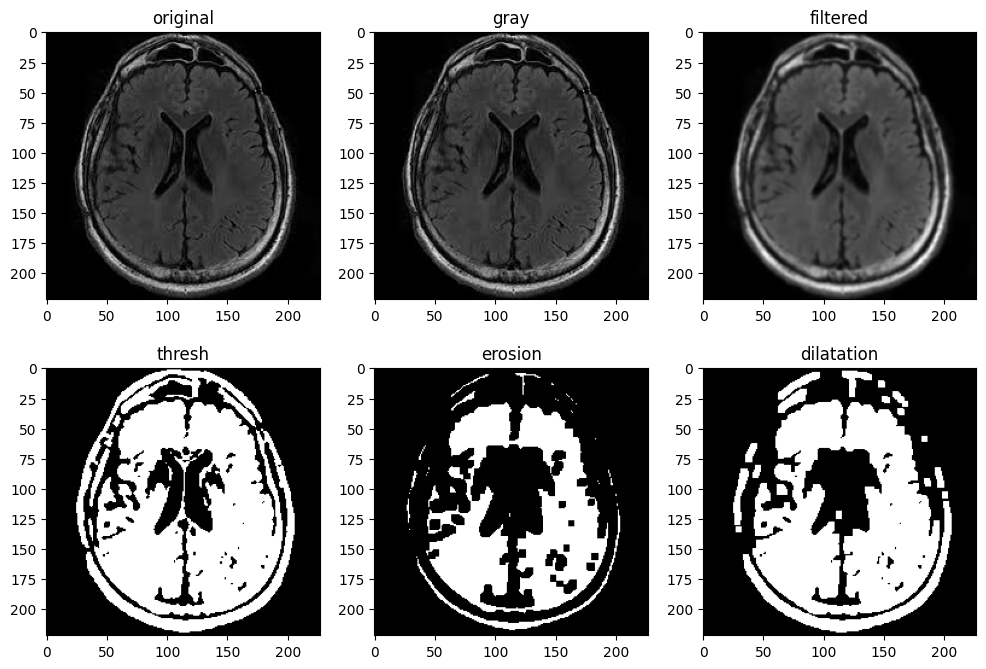

In [36]:
# preprocessing, one image, cropping https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
IMG_SIZE = (224,224)
img = X[0]

# from RGB to gray scale

#before converting it we have to check if we are losing information with the gray scale conversion
# a simple way is to calculate the entropy after and before
print(f'original entropy {entropy(img.ravel())}')
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.imshow(img)
plt.title('original')

img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.subplot(2,3,2)
plt.imshow(img,cmap='gray')
plt.title('gray')
print(f'entropy after conversion {entropy(img.ravel())}')

#TODO too much information is lost with the conversion

# gaussian filter
img = cv2.GaussianBlur(img, (5,5), 0)
plt.subplot(2,3,3)
plt.imshow(img,cmap='gray')
plt.title('filtered')


thresh = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY)[1]
plt.subplot(2,3,4)
plt.imshow(thresh,cmap='gray')
plt.title('thresh')

thresh = cv2.erode(thresh, None, iterations=2)
plt.subplot(2,3,5)
plt.imshow(thresh,cmap='gray')
plt.title('erosion')


thresh = cv2.dilate(thresh, None, iterations=2)
plt.subplot(2,3,6)
plt.imshow(thresh,cmap='gray')
plt.title('dilatation')

#TODO otsu?


# find contours in thresholded image, then grab the largest
# one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

# cnts = imutils.grab_contours(cnts)
# c = max(cnts, key=cv2.contourArea)


In [65]:
!pip install diptest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 1.3 MB/s eta 0:00:00


dip =  (0.006035969362256409, 0.9971669395762475)
dip =  (0.07672211865019682, 0.0)
mean of dip test = 0.07148333196238571
mean of dip test p-value = 0.0


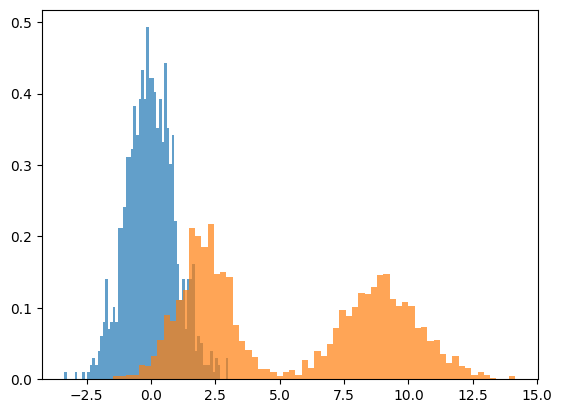

In [75]:
import diptest
#histograms
# to check if the otsu threshold technique can be applied
# the histograms must have a bimodal distribution

#example for dip test

# a normal distribution must have a very low skewness
data = np.random.normal(0,1,1000)
plt.hist(data, 64, density=True, alpha=0.7)

#the skew is near zero
print('dip = ', diptest.diptest(data))

#lets see a bimodal distribution
# Parameters for the two normal distributions
mean1 = 2.0
std_dev1 = 1.0
size1 = 1000

mean2 = 9.0
std_dev2 = 1.5
size2 = 1000

# Generate random samples from the two normal distributions
data1 = np.random.normal(mean1, std_dev1, size1)
data2 = np.random.normal(mean2, std_dev2, size2)

# Combine the two datasets to create a bimodal distribution
bimodal_data = np.concatenate((data1, data2))

plt.hist(bimodal_data, 64, density=True, alpha=0.7)

print('dip = ', diptest.diptest(bimodal_data))

# the dip test does not check for bimodality, only look if is not unimodal

dip_vector = []
dip_pvalue = []
for i in range(len(X)):
  img = X[i]
  dip_vector.append(diptest.diptest(img.ravel())[0])
  dip_pvalue.append(diptest.diptest(img.ravel())[1])
print('mean of dip test =', np.mean(dip_vector))
print('mean of dip test p-value =', np.mean(dip_pvalue))

#TODO other tests, or other packages, because is strange that the p-value is always zero
# from here https://stats.stackexchange.com/questions/156808/interpretation-of-hartigans-dip-test
# the p-value for a bimodal distribution must be between 0.05 and 0.10

# other tests mode hunting, jarque-bera, lilliefors, Silverman test, kde visual inspection